# Mammalian Enhancer Classification with Genomic Pretraining and Fine Tuning

This notebook uses the enhancer dataset to fine tune the mammalian language model and train a classification model via transfer learning. For more detail about the fine tuning process, see the [Human 4 Short Promoter Classification with Fine Tuning](https://github.com/kheyer/Genomic-ULMFiT/blob/master/Mammals/Human/Promoter%20Classification%20Short%20Sequences/Human%20Promoters%20Short%20Sequences%203%20Classification%20with%20Fine%20Tuning.ipynb) notebook.

To replicate a portion of the paper, the model will be trained on enhancer sequences from Human, Mouse, Dog and Opossum genomes. The multi-species model will then be used to predict on individual species.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.text import *
from Bio import Seq
from Bio.Seq import Seq
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.SeqFeature import FeatureLocation, CompoundLocation
from sklearn.metrics import roc_auc_score

In [3]:
sys.path.append("../../..")
from utils import *

In [4]:
path = Path('F:/genome/mammals/')

# LM Fine Tune

In [5]:
classification_df = pd.read_csv(path/'enhancer_data.csv')

In [6]:
classification_df.head()

,Sequence,Enhancer,Organism,set
0,TGCGGGGTCTTGGCTCTCACGGTCGACTCTGCCTCTCGTGCCCGGG...,positive,Cat,train
1,TCCAGCCACTCCTGAGTCAACATGGCGGGCTTTCTTTGTTGGGCTC...,positive,Cat,train
2,GTGTGCTGGCCACCAGAGGGAGCCAGATCCCCCCTTTTCTCCTCCA...,positive,Cat,train
3,TGGGCGTTTTCACTGCGCGGTCTCTGCTCCTGCCCAACCGCAAGCG...,positive,Cat,train
4,GGCATTGGAGGGACCGAGAATAGGGAGGCCCTGGCCCAAAAAATCA...,positive,Cat,train


In [7]:
species = ['Human', 'Mouse', 'Dog', 'Opossum']
classification_df = classification_df[classification_df.Organism.isin(species)]

In [8]:
train_df = classification_df[classification_df.set == 'train']
valid_df = classification_df[classification_df.set == 'valid']
test_df = classification_df[classification_df.set == 'test']

In [9]:
classification_df.Organism.unique()

array(['Dog', 'Human', 'Mouse', 'Opossum'], dtype=object)

In [10]:
train_df.shape, valid_df.shape, test_df.shape

((89598, 4), (11200, 4), (11200, 4))

In [11]:
voc = np.load(path/'mammal_vocab.npy')
model_vocab = GenomicVocab(voc)

In [12]:
tok = Tokenizer(GenomicTokenizer, n_cpus=1, pre_rules=[], post_rules=[], special_cases=['xxpad'])

In [13]:
data = GenomicTextLMDataBunch.from_df(path, train_df, valid_df, bs=800, tokenizer=tok, 
                              chunksize=10000, text_cols='Sequence', label_cols='Enhancer', vocab=model_vocab)

In [14]:
len(data.vocab.stoi), len(data.vocab.itos)

(1025, 1025)

In [17]:
config = dict(emb_sz=400, n_hid=1150, n_layers=3, pad_token=0, qrnn=False, output_p=0.25, 
                          hidden_p=0.1, input_p=0.2, embed_p=0.02, weight_p=0.15, tie_weights=True, out_bias=True)
drop_mult = 0.25

In [18]:
learn = get_model_LM(data, drop_mult, config)

In [19]:
learn.load('mammal1');

In [20]:
learn = learn.to_fp16(dynamic=True);

In [23]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


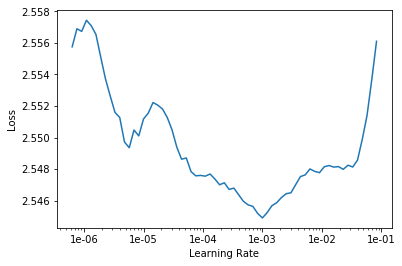

In [26]:
learn.recorder.plot(skip_end=13)

# Training


In [27]:
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,2.537246,2.517296,0.189682,04:14
1,2.517784,2.493816,0.197456,04:14
2,2.495941,2.479434,0.202786,04:12
3,2.483269,2.470397,0.206046,04:11
4,2.471441,2.463679,0.208495,04:12
5,2.464076,2.459816,0.209828,04:12
6,2.451770,2.457437,0.210490,04:11
7,2.441817,2.456240,0.211047,04:13
8,2.442688,2.455830,0.211315,04:13
9,2.437391,2.455772,0.211329,04:12


In [28]:
learn.save('encoder_LM_4o')
learn.save_encoder('encoder_LM_4o_enc')

# Classification

In [5]:
classification_df = pd.read_csv(path/'enhancer_data.csv')

In [6]:
classification_df.head()

,Sequence,Enhancer,Organism,set
0,TGCGGGGTCTTGGCTCTCACGGTCGACTCTGCCTCTCGTGCCCGGG...,positive,Cat,train
1,TCCAGCCACTCCTGAGTCAACATGGCGGGCTTTCTTTGTTGGGCTC...,positive,Cat,train
2,GTGTGCTGGCCACCAGAGGGAGCCAGATCCCCCCTTTTCTCCTCCA...,positive,Cat,train
3,TGGGCGTTTTCACTGCGCGGTCTCTGCTCCTGCCCAACCGCAAGCG...,positive,Cat,train
4,GGCATTGGAGGGACCGAGAATAGGGAGGCCCTGGCCCAAAAAATCA...,positive,Cat,train


In [7]:
species = ['Human', 'Mouse', 'Dog', 'Opossum']
classification_df = classification_df[classification_df.Organism.isin(species)]

In [8]:
train_df = classification_df[classification_df.set == 'train']
valid_df = classification_df[classification_df.set == 'valid']
test_df = classification_df[classification_df.set == 'test']

In [9]:
classification_df.Organism.unique()

array(['Dog', 'Human', 'Mouse', 'Opossum'], dtype=object)

In [10]:
train_df.shape, valid_df.shape, test_df.shape

((89598, 4), (11200, 4), (11200, 4))

In [11]:
voc = np.load(path/'mammal_vocab.npy')
model_vocab = GenomicVocab(voc)

In [12]:
tok = Tokenizer(GenomicTokenizer, n_cpus=1, pre_rules=[], post_rules=[], special_cases=['xxpad'])

In [13]:
data_clas = GenomicTextClasDataBunch.from_df(path, train_df, valid_df, tokenizer=tok, vocab=model_vocab,
                                            text_cols='Sequence', label_cols='Enhancer', bs=340)

In [14]:
len(data_clas.vocab.itos), len(data_clas.vocab.stoi)

(1025, 1025)

In [17]:
clas_config = dict(emb_sz=400, n_hid=1150, n_layers=3, pad_token=0, qrnn=False, output_p=0.4,
                       hidden_p=0.2, input_p=0.6, embed_p=0.1, weight_p=0.5)
drop_mult = 0.4

In [18]:
learn = get_model_clas(data_clas, drop_mult, clas_config)

In [19]:
learn = learn.to_fp16(dynamic=True);

In [20]:
learn.model

SequentialRNN(
  (0): MultiBatchEncoder(
    (module): AWD_LSTM(
      (encoder): Embedding(1025, 400, padding_idx=0)
      (encoder_dp): EmbeddingDropout(
        (emb): Embedding(1025, 400, padding_idx=0)
      )
      (rnns): ModuleList(
        (0): WeightDropout(
          (module): LSTM(400, 1150, batch_first=True)
        )
        (1): WeightDropout(
          (module): LSTM(1150, 1150, batch_first=True)
        )
        (2): WeightDropout(
          (module): LSTM(1150, 400, batch_first=True)
        )
      )
      (input_dp): RNNDropout()
      (hidden_dps): ModuleList(
        (0): RNNDropout()
        (1): RNNDropout()
        (2): RNNDropout()
      )
    )
  )
  (1): PoolingLinearClassifier(
    (layers): Sequential(
      (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.16000000000000003)
      (2): Linear(in_features=1200, out_features=50, bias=True)
      (3): ReLU(inplace)
      (4): BatchNorm1d(50, eps=1e

In [21]:
learn.load_encoder('encoder_LM_4o_enc')
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


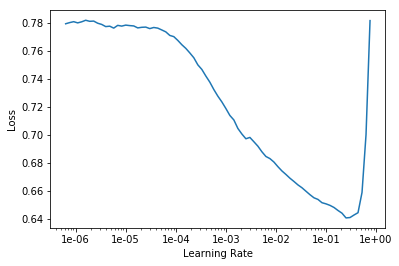

In [22]:
learn.lr_find()
learn.recorder.plot()

In [23]:
learn.fit_one_cycle(2, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.550790,0.559977,0.715804,02:06
1,0.547133,0.533695,0.730893,02:06


In [24]:
learn.freeze_to(-2)
learn.fit_one_cycle(3, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.538845,0.543227,0.725804,02:32
1,0.524762,0.519881,0.739375,02:32
2,0.505331,0.521944,0.735982,02:32


In [25]:
learn.freeze_to(-3)
learn.fit_one_cycle(3, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.503627,0.520550,0.737946,03:48
1,0.493311,0.516663,0.740446,03:48
2,0.457011,0.523584,0.742768,03:49


In [26]:
learn.unfreeze()
learn.fit_one_cycle(3, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.451977,0.526431,0.742589,04:42
1,0.444654,0.532994,0.741786,04:46
2,0.440640,0.536480,0.741696,04:41


In [27]:
learn.save('encoder_LM_4o_enc_finetune_clas')

In [21]:
learn.load('encoder_LM_4o_enc_finetune_clas');

In [22]:
data_test = GenomicTextClasDataBunch.from_df(path, train_df, test_df, 
                                                 tokenizer=tok, vocab=model_vocab, text_cols='Sequence', 
                                                 label_cols='Enhancer', bs=400)

In [23]:
learn.data = data_test
preds = learn.get_preds(ordered=True)
p = torch.argmax(preds[0], dim=1)
y = preds[1]

In [24]:
test_df['y'] = y
test_df['pred'] = p
test_df['prob'] = preds[0][:,1]

C:\Users\GATEWAY\Anaconda2\envs\fastai_v1\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\GATEWAY\Anaconda2\envs\fastai_v1\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\GATEWAY\Anaconda2\envs\fastai_v1\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

In [25]:
test_df.head()

,Sequence,Enhancer,Organism,set,y,pred,prob
433995,ATTTATCTTCTCTTATTTGCAAAAGCCTTGACGGAGAATATCCGCT...,positive,Dog,test,1,1,0.698741
433996,GCCCCCATAGGGATGCAATTGCTTGATACTAGGTGCCTTCAAACTG...,positive,Dog,test,1,0,0.426710
433997,AATATTTACTGTATACTAAAATTATTATATGTTTATTCTGATAAAA...,positive,Dog,test,1,1,0.734024
433998,AAAAAAAAAAAAAAAAAAAAAAAAAAAAACCACCTGCAAGACTGGT...,positive,Dog,test,1,0,0.258560
433999,TAAGCGTGTGGCTTCAGCTCAGGTCATGTTCTCAGGATTCTGGGAT...,positive,Dog,test,1,1,0.630827


In [28]:
for animal in species:
    print(animal)
    score = roc_auc_score(test_df[test_df.Organism == animal].y, test_df[test_df.Organism == animal].prob)
    print(score)
    
print('Overall')
print(roc_auc_score(test_df.y, test_df.prob))

Human
0.8015033163265306
Mouse
0.8615887755102041
Dog
0.7848339285714285
Opossum
0.7968002551020408
Overall
0.8108397002551021
